<a href="https://colab.research.google.com/github/OtusTeam/Machine-Learning/blob/main/%D0%9C%D0%BE%D0%B4%D1%83%D0%BB%D1%8C%207%3A%20Bayesian%20Learning%2C%20PyMC/39_BBN_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyMC3 - это среда вероятностного программирования с открытым исходным кодом, написанная на Python, которая использует Theano для вычисления градиентов с помощью автоматического дифференцирования, а также для оперативной компиляции вероятностных программ на C для повышения скорости.

While this would allow Probabilistic Programming to be applied to a much wider set of interesting problems, I believe this bridging also holds great promise for innovations in Deep Learning. Some ideas are:

- Uncertainty in predictions: As we will see below, the Bayesian Neural Network informs us about the uncertainty in its predictions. I think uncertainty is an underappreciated concept in Machine Learning as it's clearly important for real-world applications. But it could also be useful in training. For example, we could train the model specifically on samples it is most uncertain about.
- Uncertainty in representations: We also get uncertainty estimates of our weights which could inform us about the stability of the learned representations of the network.
- Regularization with priors: Weights are often L2-regularized to avoid overfitting, this very naturally becomes a Gaussian prior for the weight coefficients. We could, however, imagine all kinds of other priors, like spike-and-slab to enforce sparsity (this would be more like using the L1-norm).
- Transfer learning with informed priors: If we wanted to train a network on a new object recognition data set, we could bootstrap the learning by placing informed priors centered around weights retrieved from other pre-trained networks, like GoogLeNet.
- Hierarchical Neural Networks: A very powerful approach in Probabilistic Programming is hierarchical modeling that allows pooling of things that were learned on sub-groups to the overall population. Applied to Neural Networks, in hierarchical data sets, we could train individual neural nets to specialize on sub-groups while still being informed about representations of the overall population. For example, imagine a network trained to classify car models from pictures of cars. We could train a hierarchical neural network where a sub-neural network is trained to tell apart models from only a single manufacturer. The intuition being that all cars from a certain manufactures share certain similarities so it would make sense to train individual networks that specialize on brands. However, due to the individual networks being connected at a higher layer, they would still share information with the other specialized sub-networks about features that are useful to all brands. Interestingly, different layers of the network could be informed by various levels of the hierarchy -- e.g. early layers that extract visual lines could be identical in all sub-networks while the higher-order representations would be different. The hierarchical model would learn all that from the data.
- Other hybrid architectures: We can more freely build all kinds of neural networks. For example, Bayesian non-parametrics could be used to flexibly adjust the size and shape of the hidden layers to optimally scale the network architecture to the problem at hand during training. Currently, this requires costly hyper-parameter optimization and a lot of tribal knowledge.


In [1]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

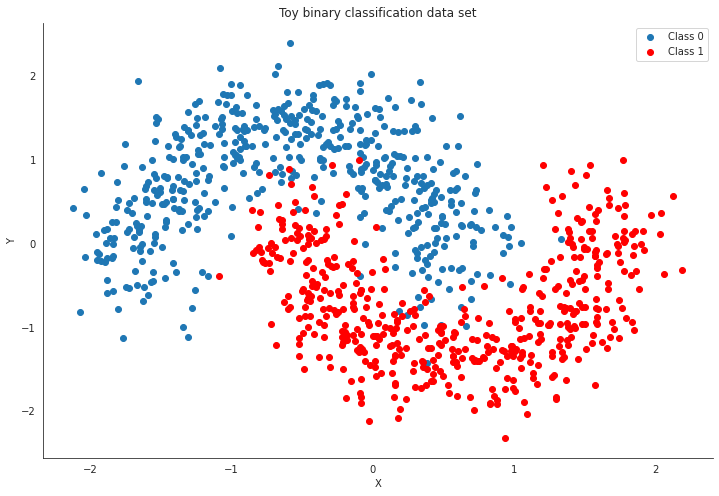

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine()
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

### Model specification

A neural network is quite simple. The basic unit is a perceptron which is nothing more than logistic regression. We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.


In [4]:
Y_train.shape

(500,)

In [12]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)



That's not so bad. The Normal priors help regularize the weights. Usually we would add a constant b to the inputs but I omitted it here to keep the code cleaner.

### Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like NUTS which works pretty well in this case, but this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use Automatic Differentation Variational Inference (ADVI) variational inference algorithm which was recently added to PyMC3, and updated to use the operator variational inference (OPVI) framework. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.


In [13]:
from pymc3.theanof import set_tt_rng
set_tt_rng(42)

In [14]:
%%time

with neural_network:
  inference = pm.ADVI()
  approx = pm.fit(n=50000, method=inference)

Finished [100%]: Average Loss = 121.49


CPU times: user 22.3 s, sys: 440 ms, total: 22.7 s
Wall time: 23.5 s


In [15]:
trace = approx.sample(draws=5000)

Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.

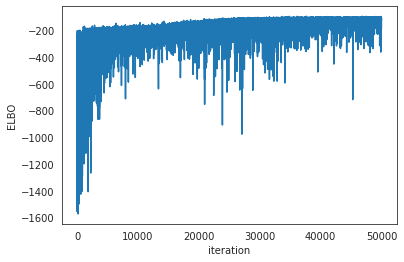

In [16]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');



Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC).


In [17]:
# create symbolic input
x = T.matrix("X")
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar("n")
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    neural_network.out.distribution.p, size=n, more_replacements={neural_network["ann_input"]: x}
)

sample_proba = theano.function([x, n], _sample_proba)

pred = sample_proba(X_test, 500).mean(0) > 0.5

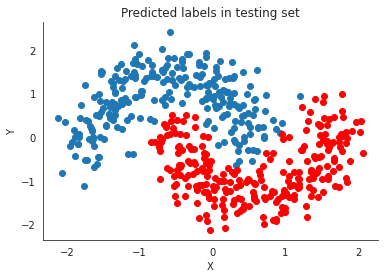

In [18]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [19]:
print(f'Accucary = {(Y_test == pred).mean() * 100}')

Accucary = 95.6



### Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.


In [20]:
grid  =pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [21]:
ppc = sample_proba(grid_2d ,500)

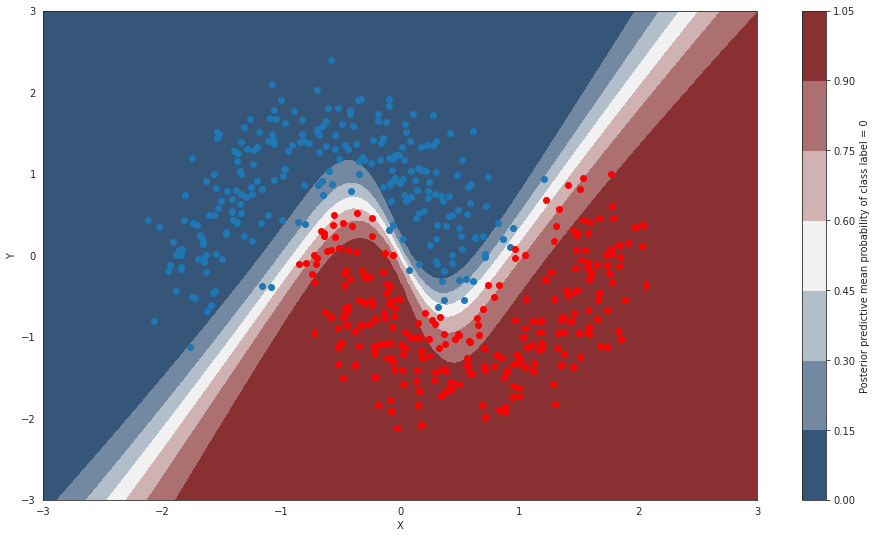

In [22]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');


### Uncertainty in predicted value

So far, everything I showed we could have done with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:


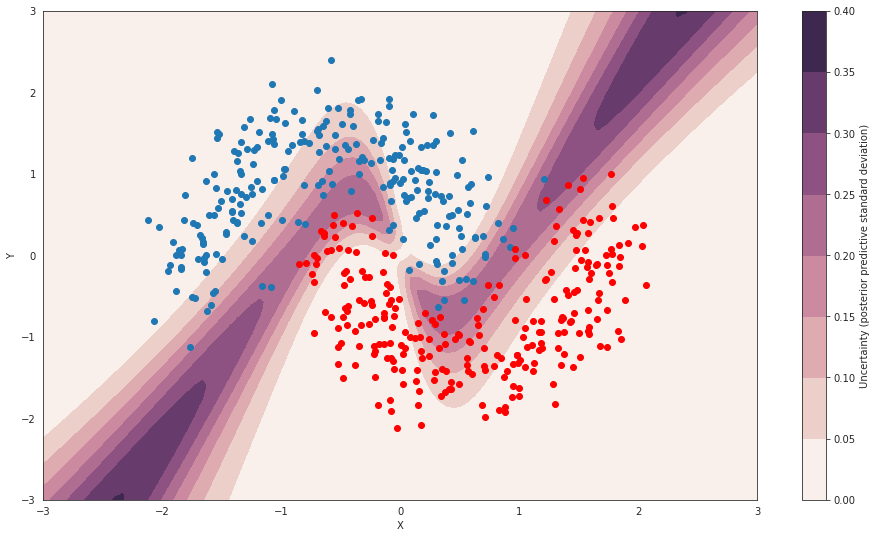

In [23]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## Mini-batch ADVI

So far, we have trained our model on all data at once. Obviously this won’t scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [24]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

Finished [100%]: Average Loss = 128.62


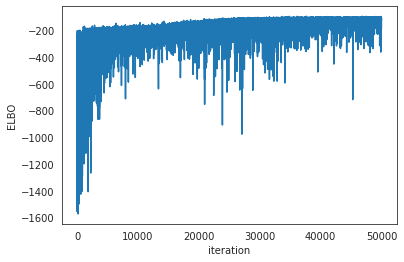

In [25]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

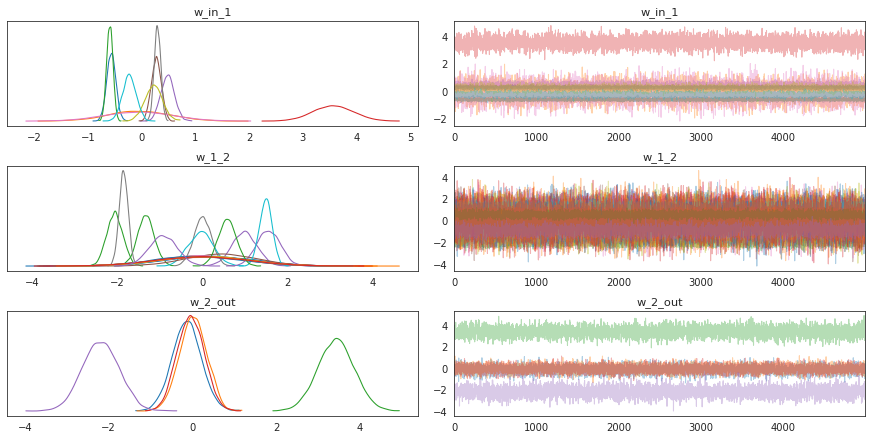

In [26]:
pm.traceplot(trace);

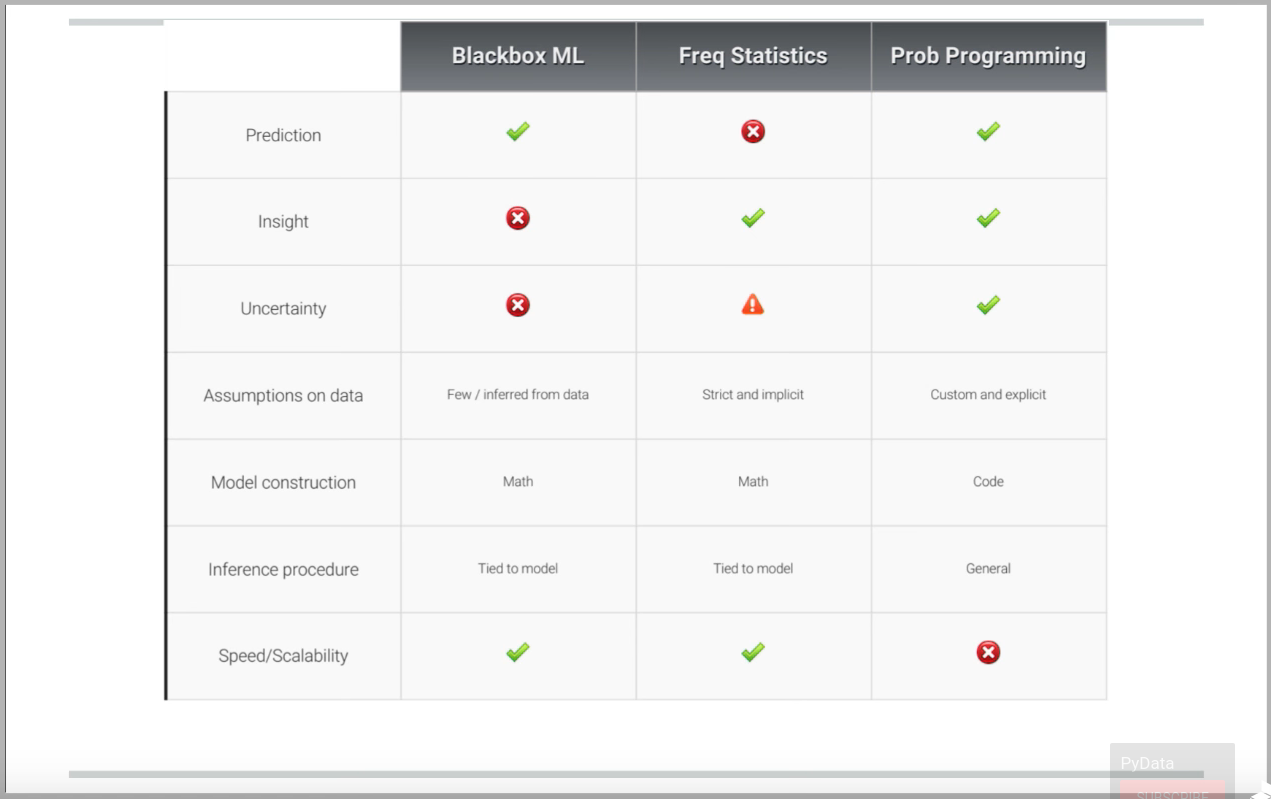

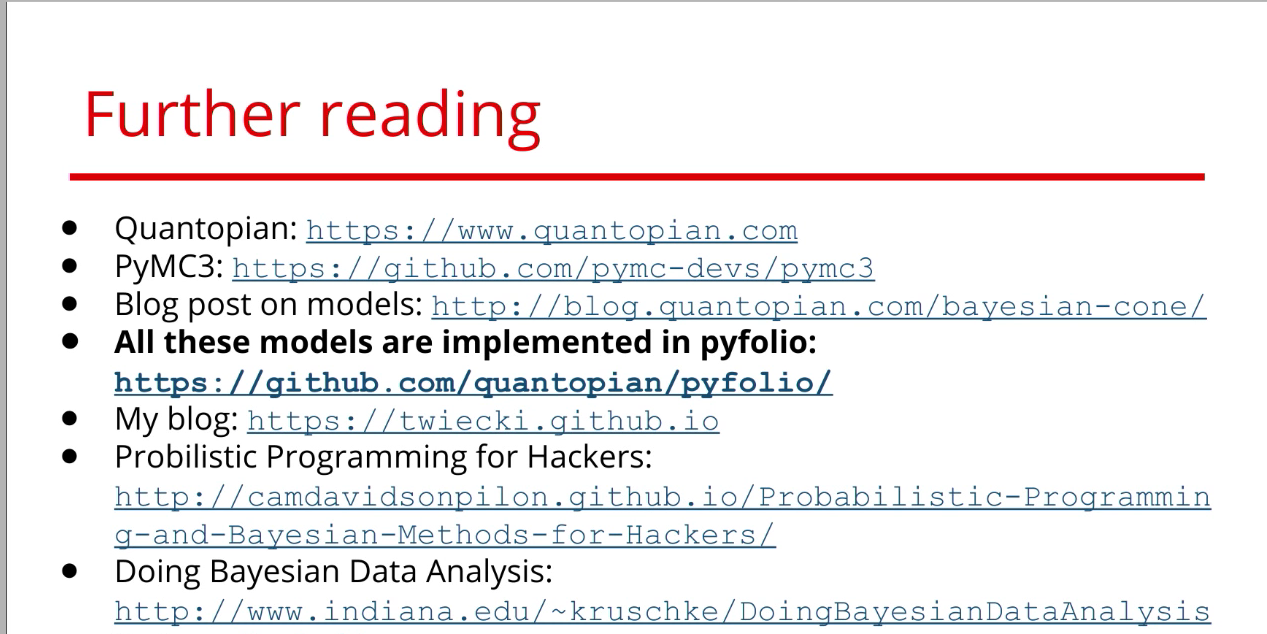